In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
#Importing libraries
import pandas as pd
import sqlite3
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [63]:
#Reading dataset
df = pd.read_csv("/content/drive/MyDrive/Data Warehousing/bank_transactions.csv")
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [64]:
#checking data types
df.dtypes

,0
TransactionID,object
CustomerID,object
CustomerDOB,object
CustGender,object
CustLocation,object
CustAccountBalance,float64
TransactionDate,object
TransactionTime,int64
TransactionAmount (INR),float64


In [65]:
#TASK A - Data Understanding
#1. Identifying null values
print("Null values in each field:\n", df.isnull().sum())

Null values in each field:
 TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64


In [66]:
#1. Removing null values
df = df.dropna()
print("Dataset shape after removing nulls:", df.shape)

Dataset shape after removing nulls: (1041614, 9)


In [67]:
#2. Identifying invalid transaction amount values (transactions <= 0)
print("Amount of invalid transactions:", df[df['TransactionAmount (INR)'] <= 0].shape[0])

#2. Removing invalid transaction amount values (transactions <= 0)
df = df[df['TransactionAmount (INR)'] > 0]
print("Dataset shape after removing invalid transactions:", df.shape)

Amount of invalid transactions: 820
Dataset shape after removing invalid transactions: (1040794, 9)


In [68]:
#3. Identifying invalid ages (under 18 and over 100)
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')

today = pd.Timestamp('today')
df['Age'] = today.year - df['CustomerDOB'].dt.year

#3. Removing invalid ages (under 18 and over 100)
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]
print("Dataset shape after removing invalid ages:", df.shape)

<ipython-input-68-82df6f503b49>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')


Dataset shape after removing invalid ages: (879720, 10)


In [69]:
#4. Displaying the 5 top Locations where the maximum number of transactions occurred
print("Top 5 Locations where the maximum number of transactions occurred:")
print(df['CustLocation'].value_counts().head(5))

# Loading cleaned data into SQLite
conn = sqlite3.connect("RFMdb")
cursor = conn.cursor()

df.to_sql("data", conn, if_exists='replace')

Top 5 Locations where the maximum number of transactions occurred:
CustLocation
MUMBAI       86278
BANGALORE    70701
NEW DELHI    66172
GURGAON      62746
DELHI        60492
Name: count, dtype: int64


879720

In [70]:
#TASK A - RFM Segmentation
#5. Defining and calculating the RFM values per Customer
#Clean data and group transactions by CustomerID
cleandata = pd.read_sql('''
    SELECT CustomerID,
           MAX(TransactionDate) AS last_order_date,
           COUNT(TransactionID) AS count_order,
           SUM("TransactionAmount (INR)") AS totalprice
    FROM data
    WHERE "TransactionAmount (INR)" > 0
      AND CustomerID IS NOT NULL
    GROUP BY CustomerID
''', conn)

#Write clean data back to database
cleandata.to_sql("cleandata", conn, if_exists='replace')

#Load cleaned data
df_Fact2 = pd.read_sql('SELECT * FROM cleandata', conn)
df_Fact2
df_Fact2.dtypes

,0
index,int64
CustomerID,object
last_order_date,object
count_order,int64
totalprice,float64


In [71]:
#5. Defining and calculating the RFM values per Customer
df_Fact2['last_order_date'] = pd.to_datetime(df_Fact2['last_order_date'], format='%d/%m/%y')
df_Fact2.dtypes
# Create date variable that records recency
df_Fact2["last_order_date"] = df_Fact2["last_order_date"].dt.date
# Create snapshot date
snapshot_date = df_Fact2['last_order_date'].max() + datetime.timedelta(days=1)
print(snapshot_date)
# Aggregate data by each customer
customers = df_Fact2.groupby(['CustomerID']).agg({
   'last_order_date': lambda x: (snapshot_date - x.max()).days,
   'count_order': 'sum',
   'totalprice': 'sum'
})
# Rename columns
customers.rename(columns = {'last_order_date': 'Recency',
                            'count_order': 'Frequency',
                            'totalprice': 'MonetaryValue'}, inplace=True)
customers.head()

2016-10-22


,Recency,Frequency,MonetaryValue
CustomerID,,,
C1010011,74,2,5106.0
C1010012,69,1,1499.0
C1010014,76,2,1455.0
C1010018,37,1,30.0
C1010028,54,1,557.0


<ipython-input-72-923630a1cded>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
<ipython-input-72-923630a1cded>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
<ipython-input-72-923630a1cded>:9: UserWarni

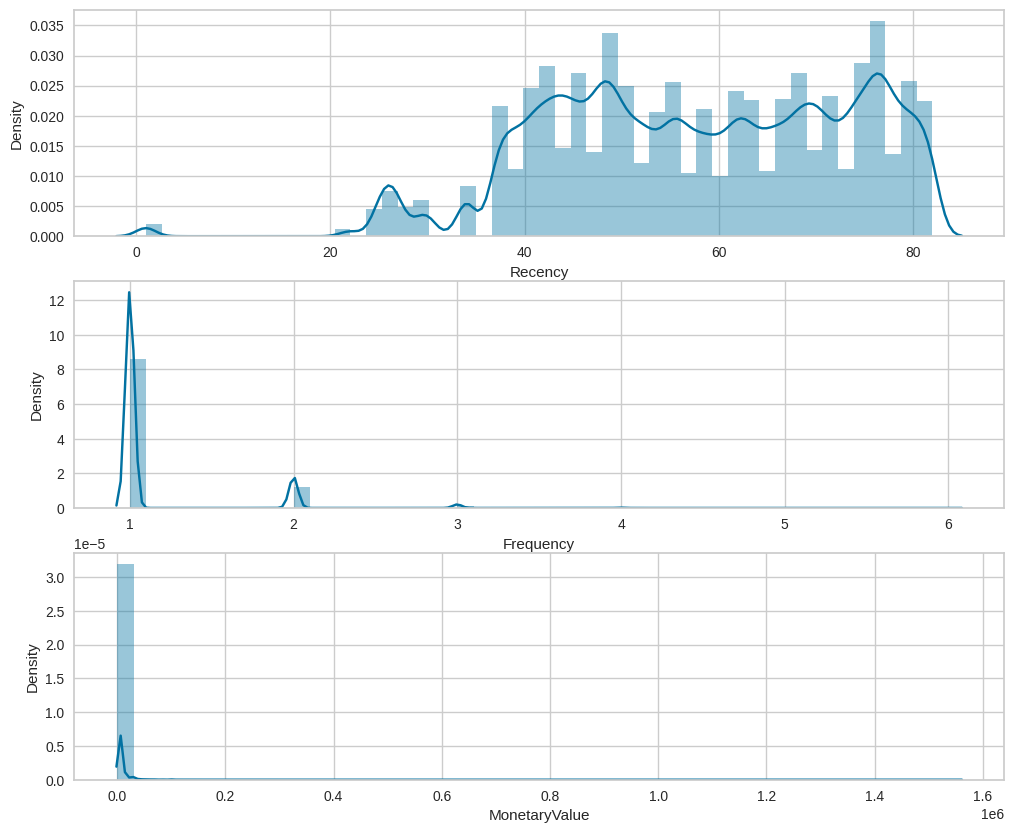

In [72]:
#6. Checking the distribution of Recency, Frequency & Monetary Values
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(customers['MonetaryValue'])
# Show the plot
plt.show()

In [73]:
#7. Removing skewness from the data
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = stats.boxcox(customers['MonetaryValue'])[0]
customers_fix.tail()

,Recency,Frequency,MonetaryValue
761358,192.597519,0.0,7.668382
761359,76.673827,0.0,6.160014
761360,157.745497,0.0,5.437504
761361,127.417738,0.0,4.299485
761362,51.111770,0.0,7.960465


<ipython-input-74-5af365513337>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers_fix['Recency'])
<ipython-input-74-5af365513337>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers_fix['Frequency'])
<ipython-input-74-5af365513337>:9: U

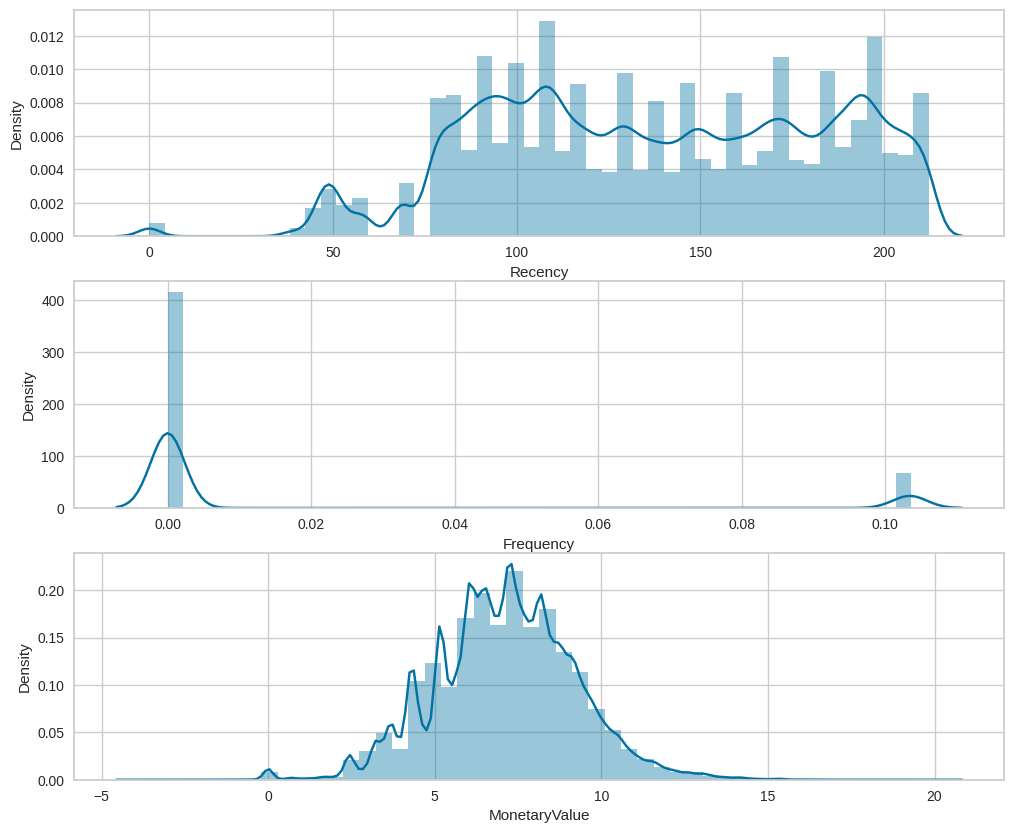

In [74]:
#7. Removing skewness from the data & plotting it
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(customers_fix['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(customers_fix['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(customers_fix['MonetaryValue'])
# Show the plot
plt.show()

In [75]:
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0.  0.]
[1. 1. 1.]


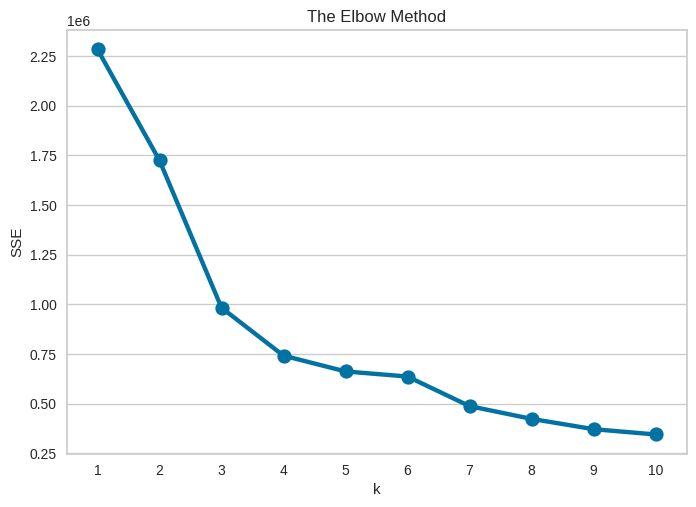

In [76]:
#Implementing K-means
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

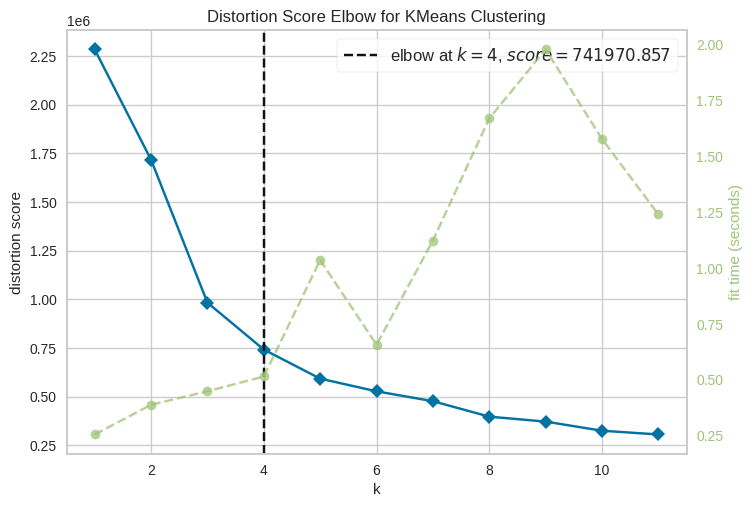

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
#Identifying best K-mean method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(customers_normalized)
visualizer.show()

,Recency,Frequency,MonetaryValue
Cluster,,,
0,266159,266159,266159
1,198887,198887,198887
2,105670,105670,105670
3,190647,190647,190647


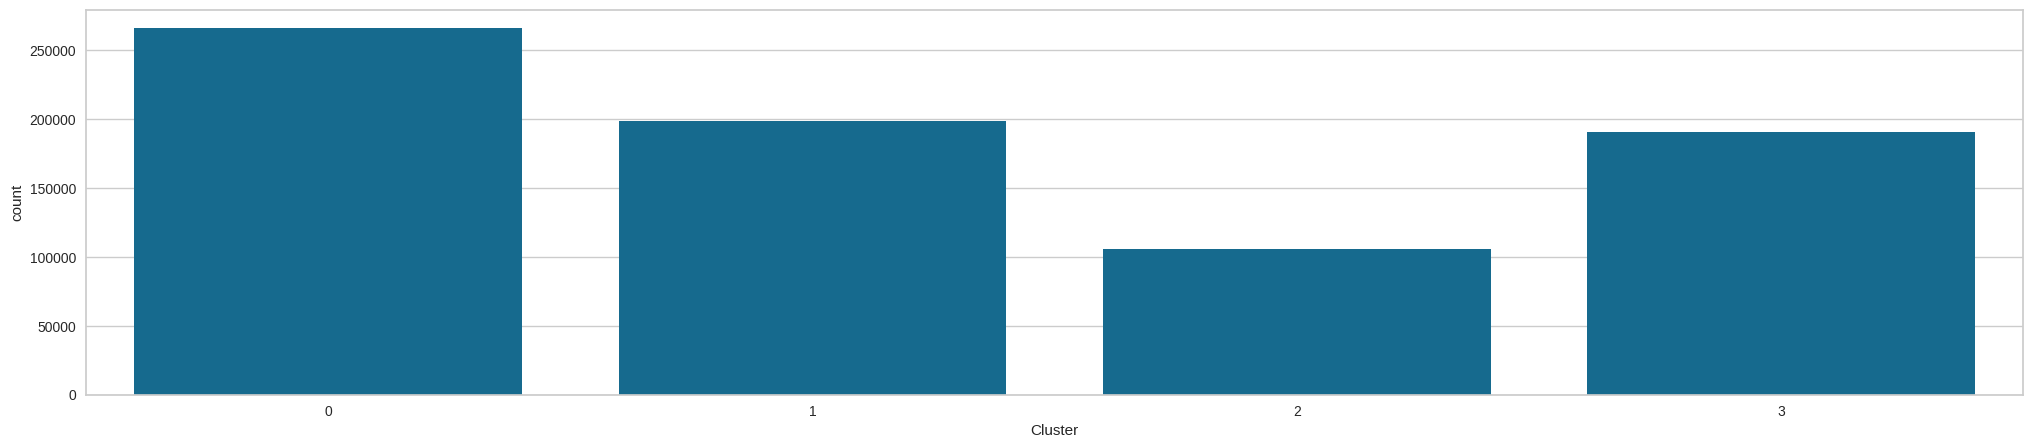

In [78]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=customers)
customers.groupby(['Cluster']).count()

In [81]:
customers.groupby(['Cluster']).count()
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
C1010011,74,2,5106.0,2
C1010012,69,1,1499.0,0
C1010014,76,2,1455.0,2
C1010018,37,1,30.0,1
C1010028,54,1,557.0,3


<Axes: xlabel='Attribute', ylabel='Value'>

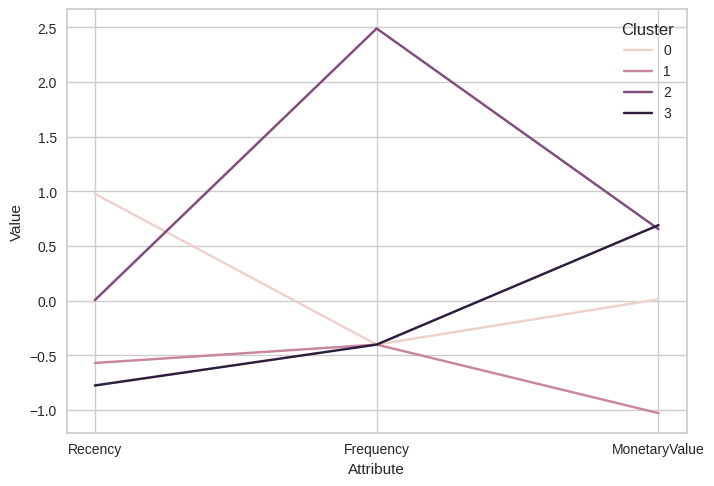

In [80]:
#Finishing implementation of K-means
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot(x = 'Attribute', y= 'Value', hue='Cluster', data=df_nor_melt)